In [1]:
# Import data from Excel sheet
import pandas as pd
#df = pd.read_excel('/content/drive/My Drive/ADNI_komplett/ADNI combined.xlsx', sheet_name='sample')
df = pd.read_excel('ADNI combined.xlsx', sheet_name='sample')
#print(df)
sid = df['RID']
grp = df['Group at scan date (1=CN, 2=EMCI, 3=LMCI, 4=AD, 5=SMC)']
age = df['Age at scan']
sex = df['Sex (1=female)']
tiv = df['TIV']
field = df['MRI_Field_Strength']
grpbin = (grp > 1) # 1=CN, ...

In [2]:
# Scan for nifti file names
import glob
dataAD = sorted(glob.glob('mwp1_MNI/AD/*.nii.gz'))
dataLMCI = sorted(glob.glob('mwp1_MNI/LMCI/*.nii.gz'))
dataCN = sorted(glob.glob('mwp1_MNI/CN/*.nii.gz'))
dataFiles = dataAD + dataLMCI + dataCN
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  663  nifti files


In [3]:
# Match covariate information
import re
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
  p = [j for j,x in enumerate(dataFiles) if re.search('_%04d_' % id, x)] # translate ID numbers to four-digit numbers, get both index and filename
  if len(p)==0:
    if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
  else:
    if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
    cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]

Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [4]:
# Load original image data from disk
import h5py
import numpy as np
from pandas import DataFrame
from keras.utils import to_categorical
hf = h5py.File('orig_images_wb_mwp1_MNI.hdf5', 'r')
hf.keys # read keys
#labels = np.array(hf.get('labels')) # note: was of data frame type before
images = np.array(hf.get('images'))
hf.close()
labels = to_categorical(np.asarray(labels)) # use grps to access original labels
print(images.shape)

Using TensorFlow backend.


(663, 100, 100, 120, 1)


In [5]:
# specify version of tensorflow
#%tensorflow_version 1.x
#%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
# downgrade to specific version
#!pip install tensorflow-gpu==1.15
#import tensorflow as tf
#print(tf.__version__)
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)
    # device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = False #True
session = tf.Session(config=config)
set_session(session)

1.15.0


In [6]:
# define function for simple data augmentation (translation of 2 vx in each x/y/z direction)
# and L/R flipping
import numpy as np
def simpleshift(arr, num, axis, fill_value=0): # adapted from https://stackoverflow.com/a/42642326
  result = np.empty_like(arr)
  if (axis==1):
    if num > 0:
        result[:, :num, :, :, :] = fill_value
        result[:, num:, :, :, :] = arr[:, :-num, :, :, :]
    elif num < 0:
        result[:, num:, :, :, :] = fill_value
        result[:, :num, :, :, :] = arr[:, -num:, :, :, :]
    else:
        result[:] = arr
    return result
  elif (axis==2):
    if num > 0:
        result[:, :, :num, :, :] = fill_value
        result[:, :, num:, :, :] = arr[:, :, :-num, :, :]
    elif num < 0:
        result[:, :, num:, :, :] = fill_value
        result[:, :, :num, :, :] = arr[:, :, -num:, :, :]
    else:
        result[:] = arr
    return result
  elif (axis==3):
    if num > 0:
        result[:, :, :, :num, :] = fill_value
        result[:, :, :, num:, :] = arr[:, :, :, :-num, :]
    elif num < 0:
        result[:, :, :, num:, :] = fill_value
        result[:, :, :, :num, :] = arr[:, :, :, -num:, :]
    else:
        result[:] = arr
    return result
  else:
    return None


In [7]:
# add new column of prediction value
grps['pred'] = -1.0

Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1364    1030
1600    5241
1307     552
1315     667
1280     230
1473    4990
238     4201
528     4707
574     4801
621     4894
1436    4251
1320     698
1459    4899
1371    1072
1376    1118
1304     505
1446    4542
1332     800
1641    6180
174     4079
640     4925
1310     610
1329     751
1327     741
4        413
209     4150
335     4384
362     4421
368     4429
381     4449
407     4496
415     4506
458     4580
478     4609
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
loading model: newmodel/newmodel_wb_cv1.hdf5




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_______________________________

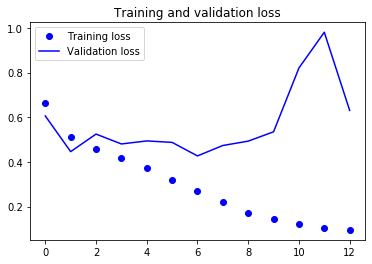

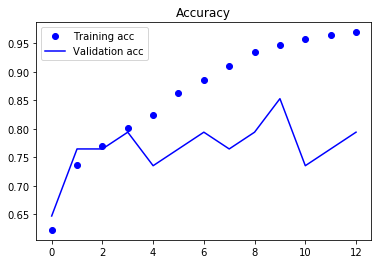

34/34 [==============================] - 0s 8ms/step
Test acc: 79.41%


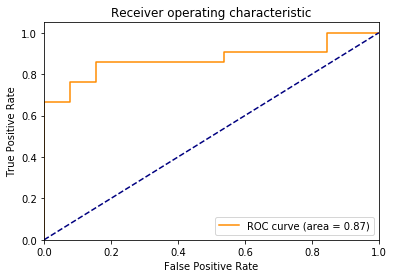

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
0.9745687
0.9082791
AUC for MCI vs. CN = 0.783
AUC for AD vs. CN = 0.969
Acc for MCI vs. CN = 70.8
Acc for AD vs. CN = 82.6
confusion matrix (naive)
[[ 9  4]
 [ 0  0]
 [ 3  8]
 [ 0 10]]
oAcc for MCI vs. CN = 79.2
oAcc for AD vs. CN = 87.0
confusion matrix (optimized)
[[12  1]
 [ 0  0]
 [ 4  7]
 [ 2  8]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1607    5252
1403    1425
1395    1346
1501    5062
1295     361
406     4494
514     4672
543     4737
615     4887
658     4982
1380    1155
1337     867
1392    1300
1400    1414
1368    1052
1397    1378
217     4162
290     4303
428     4524
513     4671
530     4712
1268     159
1243      31
1356     985
1363    1016
1274     186
164     4060
215     4158
227     4176
267     4269
305     4340
402     4485
454     4576
497     4637
Name: RID, dtype

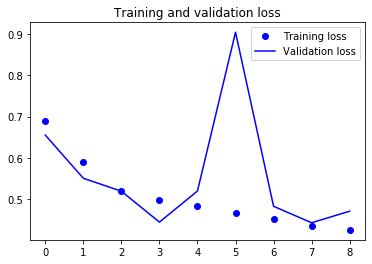

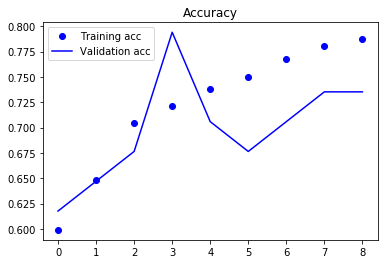

34/34 [==============================] - 0s 8ms/step
Test acc: 73.53%


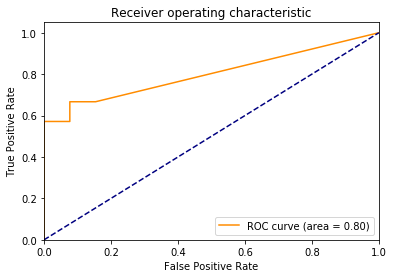

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
0.44435275
0.9783983
AUC for MCI vs. CN = 0.671
AUC for AD vs. CN = 0.942
Acc for MCI vs. CN = 66.7
Acc for AD vs. CN = 91.3
confusion matrix (naive)
[[12  1]
 [ 0  0]
 [ 7  4]
 [ 1  9]]
oAcc for MCI vs. CN = 66.7
oAcc for AD vs. CN = 91.3
confusion matrix (optimized)
[[12  1]
 [ 0  0]
 [ 7  4]
 [ 1  9]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1556    5165
1375    1117
1484    5017
1365    1043
1482    5015
1640    6142
202     4136
303     4338
534     4719
539     4728
1300     420
1426    4203
1374    1106
148     4030
161     4057
165     4061
191     4114
384     4456
554     4757
617     4889
632     4909
1335     842
1264     130
1253      74
0         21
138     4014
167     4066
295     4320
326     4372
367     4428
436     4545
462     4585
555     4762
639     4921
Name: RID, dtyp

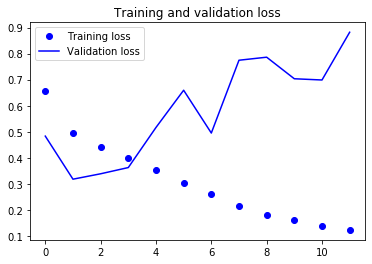

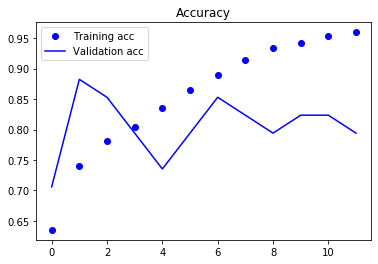

34/34 [==============================] - 0s 8ms/step
Test acc: 79.41%


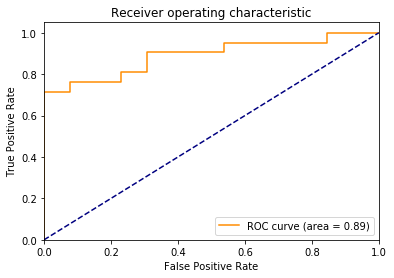

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
0.31812787
0.9999988
AUC for MCI vs. CN = 0.790
AUC for AD vs. CN = 1.000
Acc for MCI vs. CN = 70.8
Acc for AD vs. CN = 82.6
confusion matrix (naive)
[[ 9  4]
 [ 0  0]
 [ 3  8]
 [ 0 10]]
oAcc for MCI vs. CN = 70.8
oAcc for AD vs. CN = 95.7
confusion matrix (optimized)
[[ 9  4]
 [ 0  0]
 [ 3  8]
 [ 0 10]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1493    5038
1461    4924
1529    5120
1269     160
259     4252
490     4625
562     4774
589     4827
630     4906
663     5012
1646    6334
1317     671
1286     285
1262     123
1323     717
220     4169
315     4354
358     4414
386     4462
469     4595
512     4668
1355     984
1250      59
1434    4234
1340     886
1352     969
271     4275
348     4399
349     4400
363     4422
395     4474
405     4491
417     4508
502     4645
Name: RID, dtyp

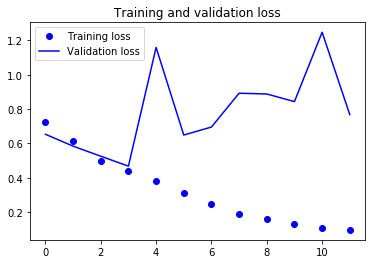

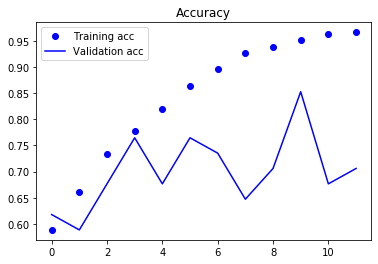

34/34 [==============================] - 0s 9ms/step
Test acc: 70.59%


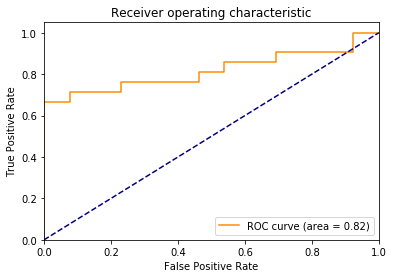

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
0.88958836
0.97362006
AUC for MCI vs. CN = 0.860
AUC for AD vs. CN = 0.769
Acc for MCI vs. CN = 70.8
Acc for AD vs. CN = 65.2
confusion matrix (naive)
[[8 5]
 [0 0]
 [2 9]
 [3 7]]
oAcc for MCI vs. CN = 79.2
oAcc for AD vs. CN = 82.6
confusion matrix (optimized)
[[12  1]
 [ 0  0]
 [ 4  7]
 [ 3  7]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1491    5032
1502    5063
1580    5205
1546    5146
1476    4997
1360    1004
262     4258
524     4692
553     4756
598     4853
1372    1074
1346     919
1435    4250
1257     107
9       1268
139     4015
150     4034
156     4042
320     4363
565     4782
601     4857
1313     657
1283     260
131     4003
176     4081
180     4086
229     4179
234     4196
273     4277
282     4290
340     4389
456     4578
464     4587
599     4855
Name: RID, dtype: int6

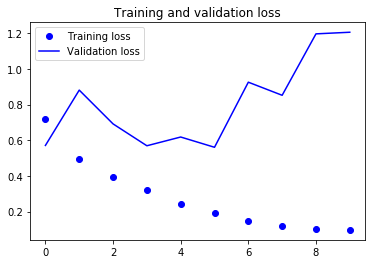

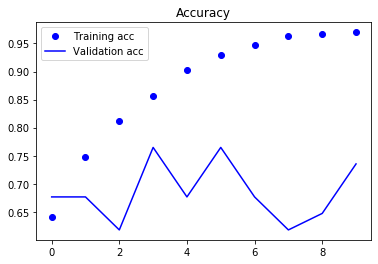

34/34 [==============================] - 0s 9ms/step
Test acc: 73.53%


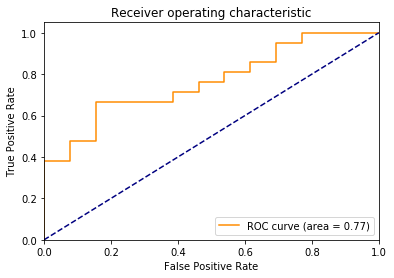

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
0.91930676
0.60455936
AUC for MCI vs. CN = 0.713
AUC for AD vs. CN = 0.823
Acc for MCI vs. CN = 75.0
Acc for AD vs. CN = 78.3
confusion matrix (naive)
[[11  2]
 [ 0  0]
 [ 4  7]
 [ 3  7]]
oAcc for MCI vs. CN = 70.8
oAcc for AD vs. CN = 73.9
confusion matrix (optimized)
[[11  2]
 [ 0  0]
 [ 5  6]
 [ 4  6]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1528    5119
1244      42
1481    5013
1362    1010
1489    5029
1621    5275
510     4660
566     4783
569     4792
650     4954
1287     291
1349     925
1463    4928
1643    6274
369     4430
459     4582
466     4590
496     4636
535     4720
545     4741
628     4904
1290     301
1637    6051
187     4100
189     4103
194     4121
196     4125
204     4139
275     4279
283     4291
313     4352
350     4401
544     4739
590     4832
Name: RID, dty

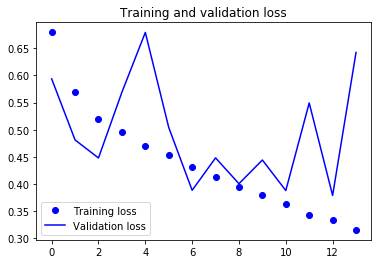

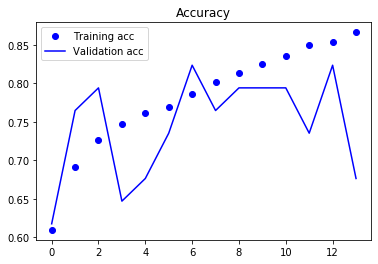

34/34 [==============================] - 0s 9ms/step
Test acc: 67.65%


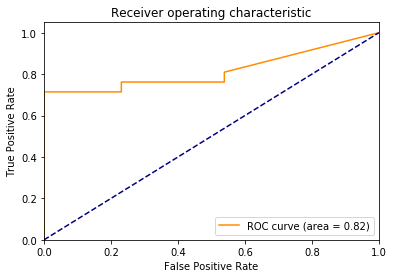

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
0.9994355
0.9994777
AUC for MCI vs. CN = 0.741
AUC for AD vs. CN = 0.900
Acc for MCI vs. CN = 58.3
Acc for AD vs. CN = 69.6
confusion matrix (naive)
[[7 6]
 [0 0]
 [4 7]
 [1 9]]
oAcc for MCI vs. CN = 79.2
oAcc for AD vs. CN = 87.0
confusion matrix (optimized)
[[13  0]
 [ 0  0]
 [ 5  6]
 [ 2  8]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1309     572
1590    5224
1314     658
1277     214
1475    4994
241     4211
465     4589
499     4641
526     4696
612     4879
1471    4985
1266     142
1460    4922
1648    6356
1390    1269
1275     200
185     4094
264     4263
346     4395
570     4793
583     4815
1308     553
1326     734
1387    1232
1336     863
8       1261
136     4010
145     4026
192     4119
251     4225
307     4345
324     4369
338     4387
371     4433
Name: RID, dtype: int64


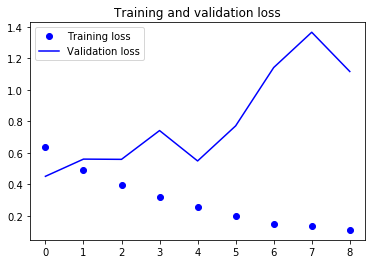

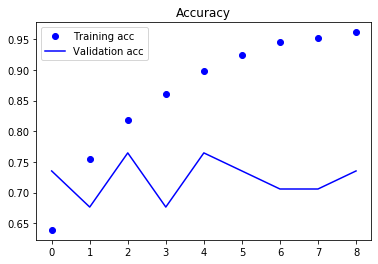

34/34 [==============================] - 0s 9ms/step
Test acc: 73.53%


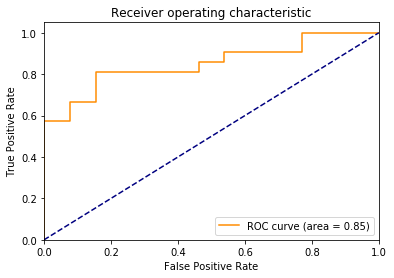

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
0.98680204
0.9656655
AUC for MCI vs. CN = 0.748
AUC for AD vs. CN = 0.962
Acc for MCI vs. CN = 62.5
Acc for AD vs. CN = 73.9
confusion matrix (naive)
[[ 7  6]
 [ 0  0]
 [ 3  8]
 [ 0 10]]
oAcc for MCI vs. CN = 70.8
oAcc for AD vs. CN = 87.0
confusion matrix (optimized)
[[11  2]
 [ 0  0]
 [ 5  6]
 [ 2  8]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1512    5087
1478    5005
1505    5070
1474    4992
135     4009
154     4039
330     4379
410     4500
429     4526
647     4949
1639    6073
1453    4804
1301     454
1443    4311
1495    5047
186     4096
426     4521
550     4746
619     4892
626     4902
651     4955
1242      23
1350     926
1302     479
1347     920
1396    1352
1292     315
153     4037
193     4120
228     4177
342     4391
455     4577
500     4643
611     4878
Name: RID, dtyp

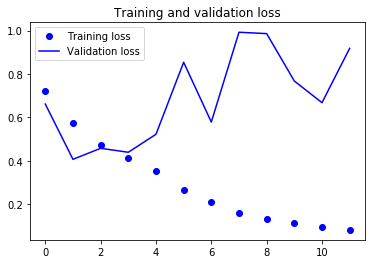

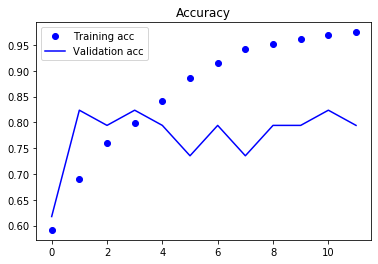

34/34 [==============================] - 0s 9ms/step
Test acc: 79.41%


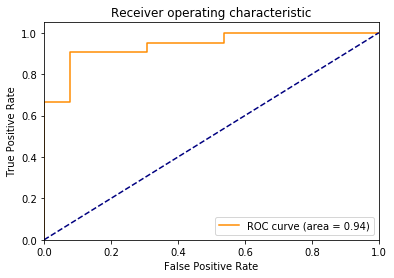

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
0.9986732
0.9998777
AUC for MCI vs. CN = 0.923
AUC for AD vs. CN = 0.962
Acc for MCI vs. CN = 70.8
Acc for AD vs. CN = 69.6
confusion matrix (naive)
[[ 6  7]
 [ 0  0]
 [ 0 11]
 [ 0 10]]
oAcc for MCI vs. CN = 87.5
oAcc for AD vs. CN = 87.0
confusion matrix (optimized)
[[12  1]
 [ 0  0]
 [ 2  9]
 [ 1  9]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1255     101
1599    5240
1293     331
1470    4980
1246      51
1404    1427
1504    5067
586     4820
595     4845
659     4984
1312     644
1465    4945
1399    1408
1421    4187
352     4403
365     4426
461     4584
532     4715
579     4807
605     4869
616     4888
1261     120
1494    5040
1245      47
1         89
3        311
157     4043
213     4155
292     4308
302     4337
309     4348
463     4586
504     4649
591     4835
Name: RID, dtype

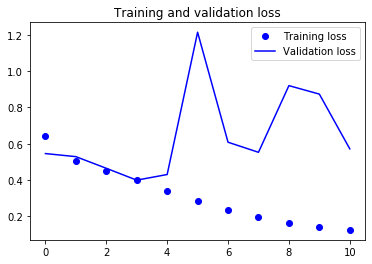

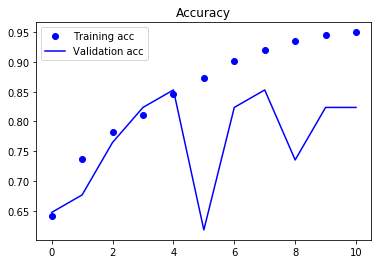

34/34 [==============================] - 0s 9ms/step
Test acc: 82.35%


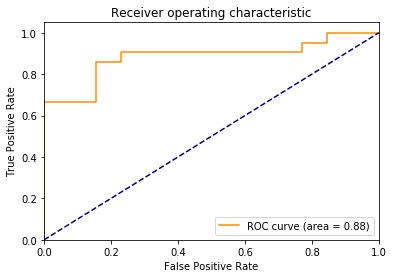

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
0.4838236
0.98737305
AUC for MCI vs. CN = 0.867
AUC for AD vs. CN = 0.900
Acc for MCI vs. CN = 79.2
Acc for AD vs. CN = 82.6
confusion matrix (naive)
[[10  3]
 [ 0  0]
 [ 2  9]
 [ 1  9]]
oAcc for MCI vs. CN = 79.2
oAcc for AD vs. CN = 87.0
confusion matrix (optimized)
[[10  3]
 [ 0  0]
 [ 2  9]
 [ 1  9]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    180
Name: Group, dtype: int64
1321     702
1361    1007
1456    4859
1636    6039
1278     227
181     4089
211     4152
243     4215
552     4755
1417    4115
1451    4729
1398    1380
1419    4167
203     4138
246     4219
286     4294
296     4324
318     4359
592     4842
657     4976
1430    4213
1344     907
1271     171
2        295
175     4080
210     4151
274     4278
317     4357
336     4385
366     4427
388     4464
414     4505
648     4951
Name: RID, dtype: int64
Dist

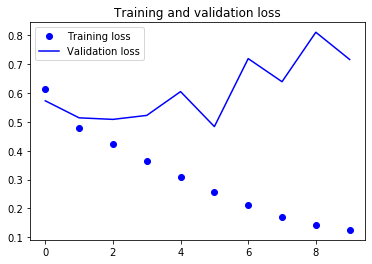

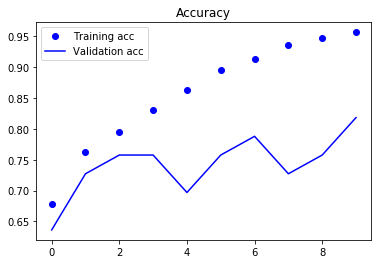

33/33 [==============================] - 0s 8ms/step
Test acc: 81.82%


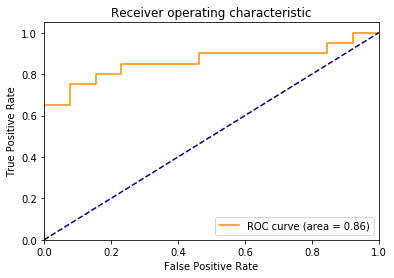

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4     9
Name: Group, dtype: int64
0.88327086
0.9978916
AUC for MCI vs. CN = 0.783
AUC for AD vs. CN = 0.957
Acc for MCI vs. CN = 75.0
Acc for AD vs. CN = 86.4
confusion matrix (naive)
[[10  3]
 [ 0  0]
 [ 3  8]
 [ 0  9]]
oAcc for MCI vs. CN = 79.2
oAcc for AD vs. CN = 86.4
confusion matrix (optimized)
[[12  1]
 [ 0  0]
 [ 4  7]
 [ 2  7]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    180
Name: Group, dtype: int64
1506    5071
1341     887
1531    5123
144     4024
276     4280
411     4501
440     4549
452     4568
561     4772
1381    1169
1402    1419
1331     778
1644    6297
5       1186
159     4053
332     4381
449     4562
506     4653
547     4743
610     4877
1458    4872
1299     419
1311     618
1348     923
1351     934
1424    4198
171     4075
224     4173
281     4288
403     4488
481     4612
522     4688
600     4856
Name: RID, dtype: int64
Dist

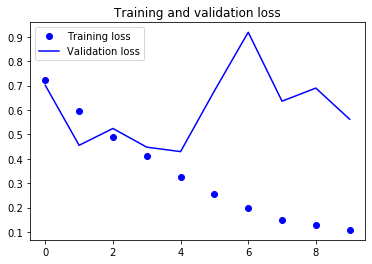

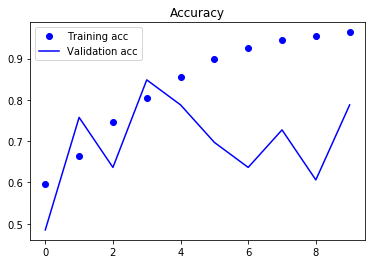

33/33 [==============================] - 0s 9ms/step
Test acc: 78.79%


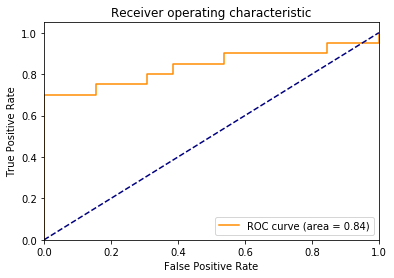

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4     9
Name: Group, dtype: int64
0.6472412
0.82377315
AUC for MCI vs. CN = 0.706
AUC for AD vs. CN = 1.000
Acc for MCI vs. CN = 70.8
Acc for AD vs. CN = 95.5
confusion matrix (naive)
[[12  1]
 [ 0  0]
 [ 6  5]
 [ 0  9]]
oAcc for MCI vs. CN = 70.8
oAcc for AD vs. CN = 95.5
confusion matrix (optimized)
[[13  0]
 [ 0  0]
 [ 7  4]
 [ 0  9]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    180
Name: Group, dtype: int64
1492    5037
1333     830
1466    4959
1468    4968
239     4209
314     4353
602     4863
603     4867
633     4910
1377    1122
1366    1045
1289     296
199     4131
257     4244
308     4346
351     4402
529     4711
531     4713
542     4736
585     4817
1428    4208
1279     229
1305     545
1316     668
237     4200
265     4266
272     4276
294     4313
328     4376
364     4424
390     4466
400     4482
485     4616
Name: RID, dtype: int64
Dist

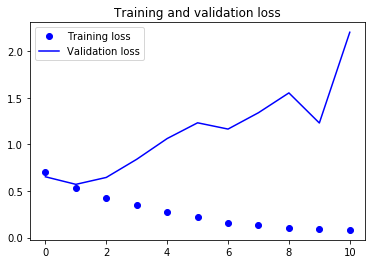

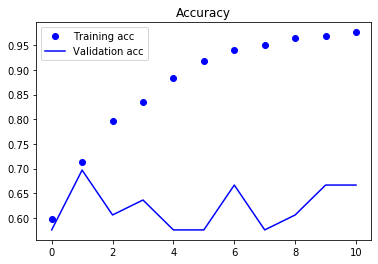

33/33 [==============================] - 0s 9ms/step
Test acc: 66.67%


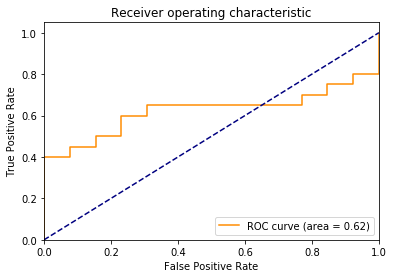

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4     9
Name: Group, dtype: int64
0.99848074
0.9999999
AUC for MCI vs. CN = 0.545
AUC for AD vs. CN = 0.718
Acc for MCI vs. CN = 62.5
Acc for AD vs. CN = 72.7
confusion matrix (naive)
[[9 4]
 [0 0]
 [5 6]
 [2 7]]
oAcc for MCI vs. CN = 62.5
oAcc for AD vs. CN = 77.3
confusion matrix (optimized)
[[10  3]
 [ 0  0]
 [ 6  5]
 [ 4  5]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    180
Name: Group, dtype: int64
1467    4964
1555    5162
1483    5016
1499    5058
1339     873
1389    1255
212     4153
223     4172
291     4307
1345     908
1367    1046
1393    1318
1423    4194
1267     150
1338     872
1440    4300
1382    1187
162     4058
235     4197
537     4722
1383    1190
1282     257
1276     210
1272     172
7       1202
155     4041
225     4174
306     4343
310     4349
393     4469
447     4559
451     4566
475     4604
Name: RID, dtype: int64
Distribution

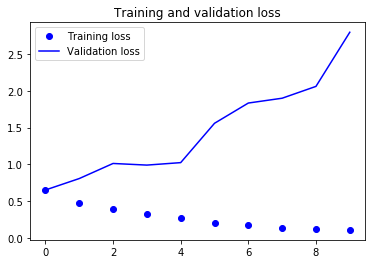

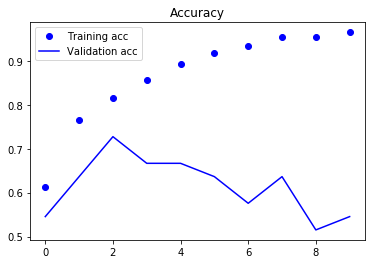

33/33 [==============================] - 0s 8ms/step
Test acc: 54.55%


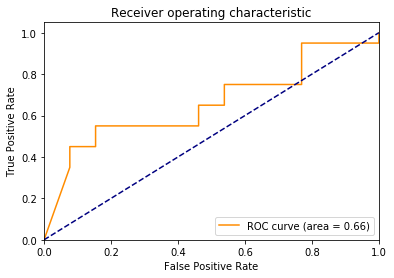

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4     9
Name: Group, dtype: int64
0.99999785
0.9999974
AUC for MCI vs. CN = 0.577
AUC for AD vs. CN = 0.761
Acc for MCI vs. CN = 41.7
Acc for AD vs. CN = 50.0
confusion matrix (naive)
[[ 3 10]
 [ 0  0]
 [ 4  7]
 [ 1  8]]
oAcc for MCI vs. CN = 62.5
oAcc for AD vs. CN = 72.7
confusion matrix (optimized)
[[11  2]
 [ 0  0]
 [ 7  4]
 [ 4  5]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    180
Name: Group, dtype: int64
1394    1326
1581    5208
1522    5106
1297     378
232     4192
249     4223
437     4546
541     4732
575     4802
1306     546
1291     307
1385    1218
1318     679
1448    4630
221     4170
254     4240
280     4287
491     4626
523     4689
538     4723
1354     981
1485    5023
1414    4050
1391    1286
182     4090
260     4254
284     4292
323     4367
325     4371
347     4396
401     4483
486     4620
501     4644
Name: RID, dtype: int64
Dist

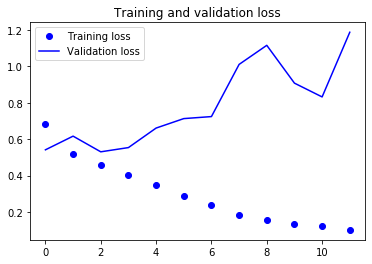

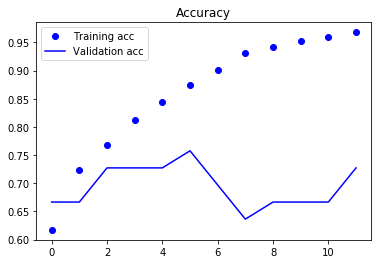

33/33 [==============================] - 0s 9ms/step
Test acc: 72.73%


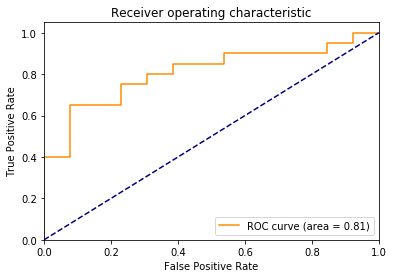

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4     9
Name: Group, dtype: int64
0.9989537
0.99946576
AUC for MCI vs. CN = 0.685
AUC for AD vs. CN = 0.957
Acc for MCI vs. CN = 62.5
Acc for AD vs. CN = 72.7
confusion matrix (naive)
[[7 6]
 [0 0]
 [3 8]
 [0 9]]
oAcc for MCI vs. CN = 66.7
oAcc for AD vs. CN = 86.4
confusion matrix (optimized)
[[12  1]
 [ 0  0]
 [ 7  4]
 [ 1  8]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    242
3    209
4    180
Name: Group, dtype: int64
1379    1130
1334     835
1497    5056
1469    4971
1479    5006
130     4001
233     4195
398     4477
521     4686
1370    1063
1450    4714
1388    1246
355     4406
356     4408
385     4458
412     4502
516     4675
563     4777
567     4784
627     4903
1303     498
1384    1206
1373    1098
6       1195
10      1280
142     4021
146     4028
190     4104
339     4388
477     4607
494     4632
571     4795
Name: RID, dtype: int64
Distribution of diagnoses

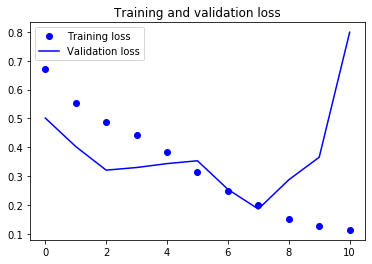

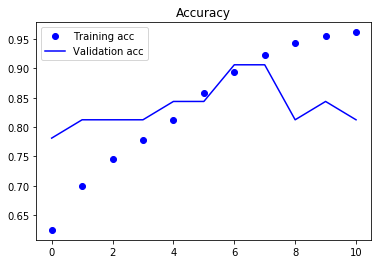

32/32 [==============================] - 0s 9ms/step
Test acc: 81.25%


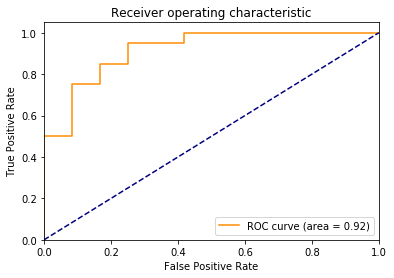

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
0.9303141
0.9999745
AUC for MCI vs. CN = 0.909
AUC for AD vs. CN = 0.926
Acc for MCI vs. CN = 73.9
Acc for AD vs. CN = 71.4
confusion matrix (naive)
[[ 6  6]
 [ 0  0]
 [ 0 11]
 [ 0  9]]
oAcc for MCI vs. CN = 82.6
oAcc for AD vs. CN = 85.7
confusion matrix (optimized)
[[ 9  3]
 [ 0  0]
 [ 1 10]
 [ 2  7]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    242
3    209
4    180
Name: Group, dtype: int64
1288     292
1359     997
1525    5112
1513    5090
1270     166
1594    5231
484     4615
540     4730
666     5019
151     4035
222     4171
416     4507
439     4548
492     4629
558     4767
578     4806
614     4885
637     4918
645     4943
653     4960
1416    4105
1254      96
1258     112
1285     272
1330     767
250     4224
263     4262
333     4382
425     4520
457     4579
472     4598
498     4638
Name: RID, dtype: int64
Distribution of di

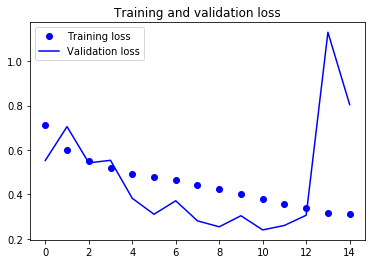

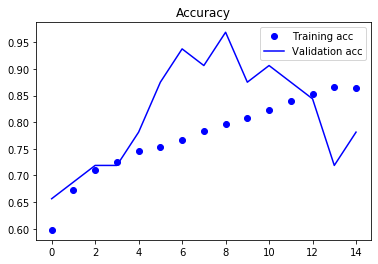

32/32 [==============================] - 0s 9ms/step
Test acc: 78.13%


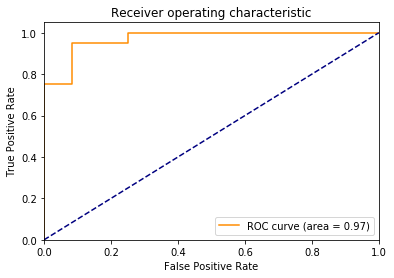

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
0.99723536
0.99995613
AUC for MCI vs. CN = 0.970
AUC for AD vs. CN = 0.972
Acc for MCI vs. CN = 69.6
Acc for AD vs. CN = 66.7
confusion matrix (naive)
[[ 5  7]
 [ 0  0]
 [ 0 11]
 [ 0  9]]
oAcc for MCI vs. CN = 91.3
oAcc for AD vs. CN = 90.5
confusion matrix (optimized)
[[11  1]
 [ 0  0]
 [ 1 10]
 [ 1  8]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    242
3    209
4    180
Name: Group, dtype: int64
1487    5027
1566    5184
1516    5095
278     4282
467     4591
533     4718
560     4770
634     4911
635     4912
1386    1226
1422    4189
1638    6056
256     4243
285     4293
493     4631
503     4646
559     4769
607     4873
642     4936
661     4989
1294     352
1273     173
1319     680
184     4093
337     4386
344     4393
380     4448
423     4516
443     4555
446     4558
473     4599
625     4900
Name: RID, dtype: int64
Distribution of 

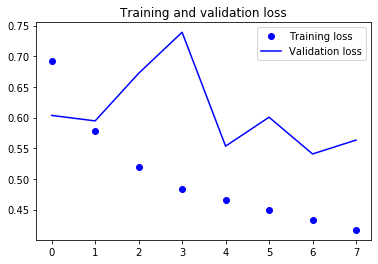

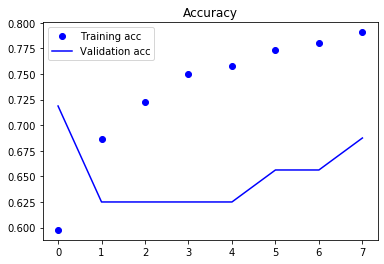

32/32 [==============================] - 0s 9ms/step
Test acc: 68.75%


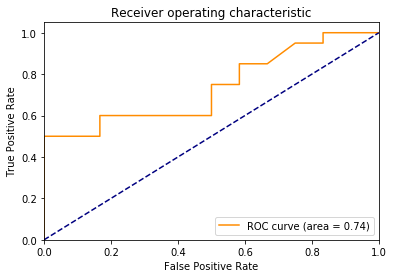

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
0.3653636
0.95856243
AUC for MCI vs. CN = 0.587
AUC for AD vs. CN = 0.921
Acc for MCI vs. CN = 60.9
Acc for AD vs. CN = 85.7
confusion matrix (naive)
[[10  2]
 [ 0  0]
 [ 7  4]
 [ 1  8]]
oAcc for MCI vs. CN = 56.5
oAcc for AD vs. CN = 90.5
confusion matrix (optimized)
[[5 7]
 [0 0]
 [3 8]
 [1 8]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    242
3    209
4    180
Name: Group, dtype: int64
1325     729
1369    1057
1568    5187
1645    6303
1606    5251
1488    5028
1542    5138
327     4373
654     4962
1649    6427
1441    4302
1328     746
345     4394
376     4444
418     4510
422     4515
433     4538
476     4605
597     4852
622     4896
1251      61
1248      56
1342     896
1259     113
141     4020
245     4218
311     4350
321     4365
374     4441
382     4453
413     4503
593     4843
Name: RID, dtype: int64
Distribution of diagnoses

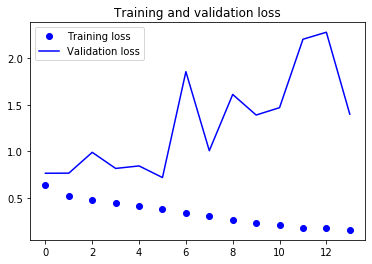

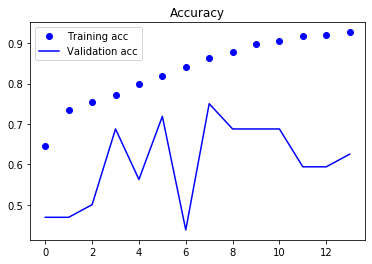

32/32 [==============================] - 0s 9ms/step
Test acc: 62.50%


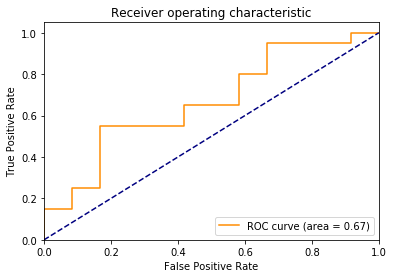

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
0.5785736
0.9430801
AUC for MCI vs. CN = 0.606
AUC for AD vs. CN = 0.741
Acc for MCI vs. CN = 56.5
Acc for AD vs. CN = 66.7
confusion matrix (naive)
[[7 5]
 [0 0]
 [5 6]
 [2 7]]
oAcc for MCI vs. CN = 60.9
oAcc for AD vs. CN = 71.4
confusion matrix (optimized)
[[10  2]
 [ 0  0]
 [ 7  4]
 [ 3  6]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    242
3    209
4    180
Name: Group, dtype: int64
1572    5196
1498    5057
1496    5054
1298     408
1358     994
460     4583
517     4676
643     4940
665     5018
1432    4229
1642    6258
1357     989
1322     709
147     4029
173     4077
240     4210
242     4214
404     4489
470     4596
641     4929
1439    4270
1252      69
1437    4255
140     4018
172     4076
178     4084
207     4148
248     4222
301     4335
304     4339
409     4499
505     4652
Name: RID, dtype: int64
Distribution of diagnoses 

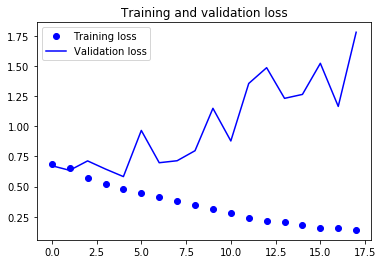

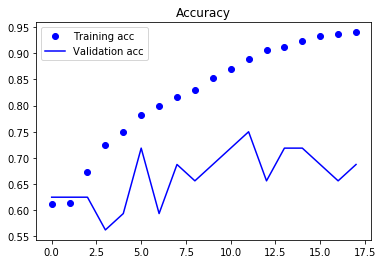

32/32 [==============================] - 0s 9ms/step
Test acc: 68.75%


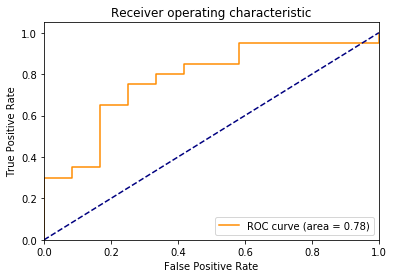

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
0.0020556082
0.36203983
AUC for MCI vs. CN = 0.652
AUC for AD vs. CN = 0.926
Acc for MCI vs. CN = 60.9
Acc for AD vs. CN = 85.7
confusion matrix (naive)
[[10  2]
 [ 0  0]
 [ 7  4]
 [ 1  8]]
oAcc for MCI vs. CN = 60.9
oAcc for AD vs. CN = 85.7
confusion matrix (optimized)
[[5 7]
 [0 0]
 [2 9]
 [0 9]]
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    242
3    209
4    180
Name: Group, dtype: int64
1296     376
1343     906
1583    5210
1284     269
1265     135
1500    5059
1353     973
508     4657
629     4905
1447    4543
1401    1418
1647    6336
195     4122
322     4366
329     4377
431     4531
480     4611
507     4654
536     4721
551     4750
1415    4097
1249      58
1324     722
149     4032
177     4082
183     4092
218     4164
357     4410
378     4446
441     4552
448     4560
649     4952
Name: RID, dtype: int64
Distribution of diagno

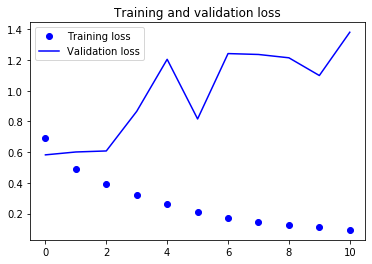

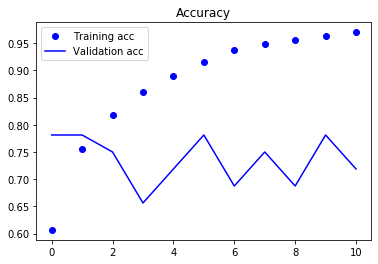

32/32 [==============================] - 0s 9ms/step
Test acc: 71.88%


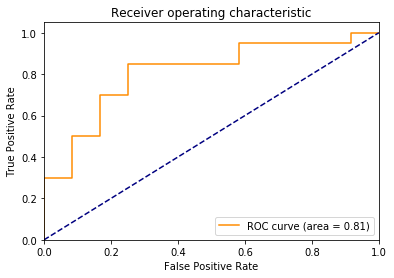

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
0.23672588
0.9714965
AUC for MCI vs. CN = 0.750
AUC for AD vs. CN = 0.880
Acc for MCI vs. CN = 65.2
Acc for AD vs. CN = 81.0
confusion matrix (naive)
[[9 3]
 [0 0]
 [5 6]
 [1 8]]
oAcc for MCI vs. CN = 73.9
oAcc for AD vs. CN = 81.0
confusion matrix (optimized)
[[9 3]
 [0 0]
 [3 8]
 [1 8]]


In [8]:
# Split data into training/validation and holdout test data
from sklearn.model_selection import StratifiedKFold,train_test_split
import numpy as np
import gc
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # model will be trained on GPU 0

import keras
from keras import layers
from keras.layers.normalization import BatchNormalization
from keras import models
from keras.optimizers import Adam
from keras import initializers
from keras.callbacks import EarlyStopping
import tensorflow as tf
from statistics import mean,stdev
from sklearn.metrics import confusion_matrix

acc_AD, acc_MCI, auc_AD, auc_MCI = [], [], [], []
opt_acc_AD, opt_acc_MCI, auc_test, acc_test = [], [], [], []
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
k = 1
for train_idX, test_idX in skf.split(X=images, y=grps.iloc[:, 0]): # split data as tenfold stratified cross-validation
    gc.collect() # run garbage collector
    print('Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]')
    print(grps.iloc[train_idX, :].Group.value_counts())
    testgrps = grps.iloc[test_idX, :]
    print(testgrps.RID) # prints test RID
    print('Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]')
    print(testgrps.Group.value_counts())
    
    # Setup CNN model
    tf.set_random_seed(k)
    #3D convnet model
    #input_shape = images.shape[1:]

    #model = models.Sequential()
    # Convolution Layers
    #model.add(layers.Conv3D(5, (3, 3, 3), padding='same', activation='relu',
    #          input_shape=input_shape, data_format='channels_last'))
    #model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    #model.add(layers.BatchNormalization())

    #model.add(layers.Conv3D(5, (3, 3, 3), padding='same', activation='relu'))
    #model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    #model.add(layers.BatchNormalization())

    #model.add(layers.Conv3D(5, (3, 3, 3), padding='same', activation='relu'))
    #model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    #model.add(layers.BatchNormalization())
    
    # FC layers
    #model.add(layers.Flatten())
    #model.add(layers.Dense(64, activation='relu'))
    #model.add(layers.Dropout(rate = 0.1))
    #model.add(layers.Dense(32, activation='relu', kernel_regularizer='l2'))
    #model.add(layers.Dropout(rate = 0.1))
    #model.add(layers.Dense(2, activation='softmax', kernel_regularizer='l2'))

    print('loading model: newmodel/newmodel_wb_cv%d.hdf5' % (k))
    model = models.load_model('newmodel/newmodel_wb_cv%d.hdf5' % (k))

    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if k==1:
        model.summary()
    
    traindat = images[train_idX, :]
    train_Y = labels[train_idX, :]
    testdat = images[test_idX, :]
    test_Y = labels[test_idX, :]
    #del images # try to free some memory

    num_train_scans = traindat.shape[0]
    num_copies = 14
    traindatA = np.zeros((num_train_scans*num_copies,) + traindat.shape[1:], dtype=traindat.dtype)
    traindatA[0:num_train_scans, :, :, :, :] = traindat
    traindatA[num_train_scans:(2*num_train_scans), :, :, :, :] = simpleshift(traindat, -10, 1) # move around x-axis
    traindatA[2*num_train_scans:(3*num_train_scans), :, :, :, :] = simpleshift(traindat, 10, 1)
    traindatA[3*num_train_scans:(4*num_train_scans), :, :, :, :] = simpleshift(traindat, -10, 2) # move around y-axis
    traindatA[4*num_train_scans:(5*num_train_scans), :, :, :, :] = simpleshift(traindat, 10, 2)
    traindatLRshifted = np.fliplr(traindat) # flip L/R
    traindatA[5*num_train_scans:(6*num_train_scans), :, :, :, :] = traindatLRshifted
    traindatA[6*num_train_scans:(7*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, 10, 1) # move around x-axis
    traindatA[7*num_train_scans:(8*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, -10, 1)
    traindatA[8*num_train_scans:(9*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, 10, 2) # move around y-axis
    traindatA[9*num_train_scans:(10*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, -10, 2)
    traindatA[10*num_train_scans:(11*num_train_scans), :, :, :, :] = simpleshift(traindat, 10, 3) # move around z-axis
    traindatA[11*num_train_scans:(12*num_train_scans), :, :, :, :] = simpleshift(traindat, -10, 3)
    traindatA[12*num_train_scans:(13*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, 10, 3)
    traindatA[13*num_train_scans:(14*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, -10, 3)

    train_label = np.concatenate((train_Y, train_Y, train_Y, train_Y, train_Y, train_Y, train_Y, train_Y,
                                  train_Y, train_Y, train_Y, train_Y, train_Y, train_Y),
                                 axis=0)

    # Fit model to training data
    batch_size = 12
    epochs = 20 # validation accuracy doesn't increase any more after 5 epochs
    hist = model.fit(traindatA, train_label, batch_size=batch_size, epochs=epochs, verbose=1, 
                     validation_data=(testdat, test_Y), 
                     callbacks=[EarlyStopping(monitor='acc', mode='auto', verbose=1, patience=2, min_delta=0.02)])
    # Display models statistics
    from matplotlib import pyplot as plt
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    epochsr = range(len(loss))
    plt.figure()
    plt.plot(epochsr, loss, 'bo', label='Training loss')
    plt.plot(epochsr, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(epochsr, acc, 'bo', label='Training acc')
    plt.plot(epochsr, val_acc, 'b', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    mymodel = hist.model
    mymodel.save('newmodel_rawdata_pretrained/newmodel_wb_cv%d.hdf5' % k)
    k = k+1
    
    # Calculate accuracy for holdout test data
    scores = mymodel.evaluate(testdat, test_Y, batch_size=batch_size) #, verbose=0
    print("Test %s: %.2f%%" % (mymodel.metrics_names[1], scores[1]*100))
    acc_test.append(scores[1]*100)
    
    # calculate area under the curve
    # AUC as optimization function during training: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
    pred = mymodel.predict(testdat, batch_size=batch_size)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    acc = dict()
    opt_acc = dict()
    thresh = dict()
    for i in range(2): # classes dummy vector: 0 - CN, 1 - MCI/AD
        fpr[i], tpr[i], _ = roc_curve(test_Y[:, i], pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    auc_test.append(roc_auc[1])
    
    testgrps = grps.iloc[test_idX, :]
    #print(testgrps) # prints diagnosis and RID

    print('Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]')
    print(testgrps.Group.value_counts())

    # redo AUC for binary comparison: AD vs. HC and MCI vs. HC
    for i in [3,4]:
      grpi = np.equal(testgrps.Group.to_numpy(dtype=np.int), np.ones((testgrps.shape[0],), dtype=np.int)*i)
      grp1 = np.equal(testgrps.Group.to_numpy(dtype=np.int), np.ones((testgrps.shape[0],), dtype=np.int))
      grpidx = np.logical_or(grpi, grp1)
      fpr[i], tpr[i], thresholds = roc_curve(test_Y[grpidx, 1], pred[grpidx, 1])
      thresh[i] = thresholds[np.argmax(tpr[i] - fpr[i])]
      print(thresh[i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      acc[i] = np.mean((test_Y[grpidx, 1] == np.round(pred[grpidx, 1])).astype(int))*100
      opt_acc[i] = np.mean((test_Y[grpidx, 1] == (pred[grpidx, 1]>thresh[i]).astype(int)).astype(int))*100

    auc_AD.append(roc_auc[4])
    auc_MCI.append(roc_auc[3])
    acc_AD.append(acc[4])
    acc_MCI.append(acc[3])
    opt_acc_AD.append(opt_acc[4])
    opt_acc_MCI.append(opt_acc[3])
    
    print('AUC for MCI vs. CN = %0.3f' % roc_auc[3])
    print('AUC for AD vs. CN = %0.3f' % roc_auc[4])
    print('Acc for MCI vs. CN = %0.1f' % acc[3])
    print('Acc for AD vs. CN = %0.1f' % acc[4])
    print('confusion matrix (naive)')
    confmat = confusion_matrix(testgrps.Group-1, np.round(pred[:, 1]))
    print(confmat[:,(0,1)])
    print('oAcc for MCI vs. CN = %0.1f' % opt_acc[3])
    print('oAcc for AD vs. CN = %0.1f' % opt_acc[4])
    print('confusion matrix (optimized)')
    confmat = confusion_matrix(testgrps.Group-1, (pred[:, 1]>thresh[3]).astype(int)) ## use MCI threshold
    print(confmat[:,(0,1)])

In [9]:
# print model performance summary
print('Mean Acc for MCI vs. CN = %0.1f +/- %0.1f' % (mean(acc_MCI), stdev(acc_MCI)))
print('Mean Acc for AD vs. CN = %0.1f +/- %0.1f' % (mean(acc_AD), stdev(acc_AD)))
print('Mean oAcc for MCI vs. CN = %0.1f +/- %0.1f' % (mean(opt_acc_MCI), stdev(opt_acc_MCI)))
print('Mean oAcc for AD vs. CN = %0.1f +/- %0.1f' % (mean(opt_acc_AD), stdev(opt_acc_AD)))
print('Mean AUC for MCI vs. CN = %0.3f +/- %0.3f' % (mean(auc_MCI), stdev(auc_MCI)))
print('Mean AUC for AD vs. CN = %0.3f +/- %0.3f' % (mean(auc_AD), stdev(auc_AD)))

print('results details:')
results = pd.DataFrame({'Accuracy_MCI':acc_MCI, 'Accuracy_AD':acc_AD, 'AUC_MCI':auc_MCI, 'AUC_AD':auc_AD, 
                        'Opt_acc_MCI':opt_acc_MCI, 'Opt_acc_AD':opt_acc_AD})
print(results)

fpr_all, tpr_all, thresholds_all = roc_curve(labels[:, 1], grps.pred)
thresh_all = thresholds_all[np.argmax(tpr_all - fpr_all)]
print(thresh_all)
roc_auc_all = auc(fpr_all, tpr_all)
acc_all = np.mean((labels[:, 1] == np.round(grps.pred)).astype(int))*100
opt_acc_all = np.mean((labels[:, 1] == (grps.pred>thresh_all).astype(int)).astype(int))*100

confmat = confusion_matrix(grps.Group-1, (grps.pred>thresh_all).astype(int))
print('Naive accuracy: %0.1f %%' % acc_all)
print('confusion matrix (naive)')
print(confusion_matrix(grps.Group-1, np.round(grps.pred))[:,(0,1)])

print('Optimized accuracy: %0.1f %%' % opt_acc_all)
print('confusion matrix (optimized)')
print(confmat[:,(0,1)])

Mean Acc for MCI vs. CN = 66.2 +/- 8.5
Mean Acc for AD vs. CN = 76.5 +/- 10.7
Mean oAcc for MCI vs. CN = 72.6 +/- 9.5
Mean oAcc for AD vs. CN = 85.1 +/- 6.8
Mean AUC for MCI vs. CN = 0.743 +/- 0.120
Mean AUC for AD vs. CN = 0.899 +/- 0.089
results details:
    Accuracy_MCI  Accuracy_AD   AUC_MCI    AUC_AD  Opt_acc_MCI  Opt_acc_AD
0      70.833333    82.608696  0.783217  0.969231    79.166667   86.956522
1      66.666667    91.304348  0.671329  0.942308    66.666667   91.304348
2      70.833333    82.608696  0.790210  1.000000    70.833333   95.652174
3      70.833333    65.217391  0.860140  0.769231    79.166667   82.608696
4      75.000000    78.260870  0.713287  0.823077    70.833333   73.913043
5      58.333333    69.565217  0.741259  0.900000    79.166667   86.956522
6      62.500000    73.913043  0.748252  0.961538    70.833333   86.956522
7      70.833333    69.565217  0.923077  0.961538    87.500000   86.956522
8      79.166667    82.608696  0.867133  0.900000    79.166667   86.